In [1]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import datetime

In [2]:
inicio = ''
fin = ''

In [3]:
# Parameters
inicio = "2021-02-01"
fin = "2021-03-12"


In [4]:
vacunados = pd.read_csv('./datos_crudos/vacunas/vacunas.csv')

In [5]:
vacunados['fecha'] = pd.to_datetime(vacunados['fecha'],format='%d/%m/%Y')
vacunados = vacunados[(vacunados['fecha']>=inicio)&(vacunados['fecha']<=fin)]

Datos con fecha de corte al: 06/05/2021

## Personas vacunadas

In [6]:
vacunados.head()

,fecha,dosis_total,primera_dosis,segunda_dosis
3,2021-02-04,6228,6228,0
4,2021-02-17,8190,6228,1962
5,2021-02-24,24492,20784,3708
6,2021-03-01,42114,35886,6228
7,2021-03-04,59316,53088,6228


<AxesSubplot:xlabel='fecha'>

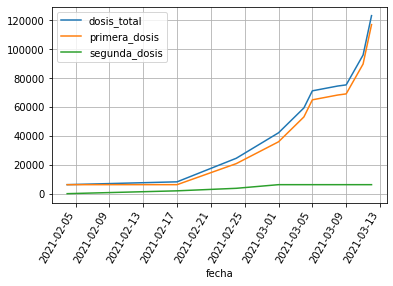

In [7]:
vacunados.plot(x='fecha', rot=60, grid=True)

## Fabricantes

In [8]:
# Datos vacunas de fabricantes por fecha de llegada
fab = pd.read_csv('./datos_crudos/vacunas/fabricantes.csv')
fab['arrived_at'] = pd.to_datetime(fab['arrived_at'],format='%d/%m/%Y')
fab = fab[(fab['arrived_at']>=inicio)&(fab['arrived_at']<=fin)]
fab.head()

,vaccine,total,arrived_at
1,Pfizer/BioNTech,16380,2021-02-17
2,Pfizer/BioNTech,17550,2021-02-24
3,Pfizer/BioNTech,31590,2021-03-03
4,Sinovac,20000,2021-03-06
5,Pfizer/BioNTech,73710,2021-03-10


In [9]:
fabAgr = fab.groupby(['vaccine'], as_index=False)['total'].sum()

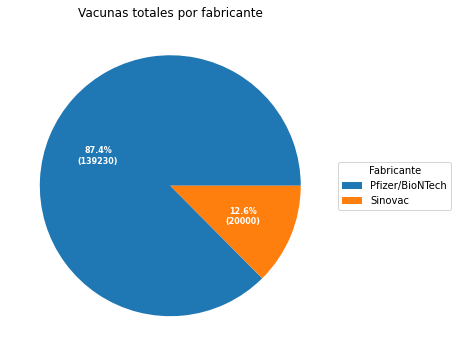

In [10]:
# Pie chart: Fabricantes Total
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(fabAgr['total'], autopct=lambda pct: func(pct, fabAgr['total']),
                                  textprops=dict(color="w"))

ax.legend(wedges, fabAgr['vaccine'],
          title="Fabricante",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Vacunas totales por fabricante")
plt.show()

## Vacunas: Mes de llegada y fabricante

In [11]:
fabAgrMonth = fab.copy()
fabAgrMonth['arrived_at'] = fabAgrMonth['arrived_at'].astype(str).str.slice(0,7)
fabAgrMonth = fabAgrMonth.groupby(['vaccine','arrived_at'], as_index=False)['total'].sum()
fabAgrMonth.head()

,vaccine,arrived_at,total
0,Pfizer/BioNTech,2021-02,33930
1,Pfizer/BioNTech,2021-03,105300
2,Sinovac,2021-03,20000


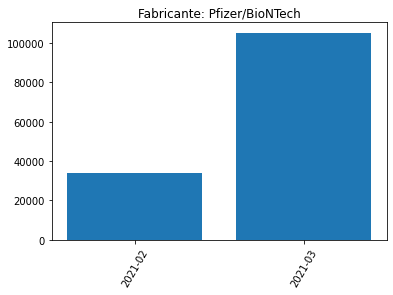

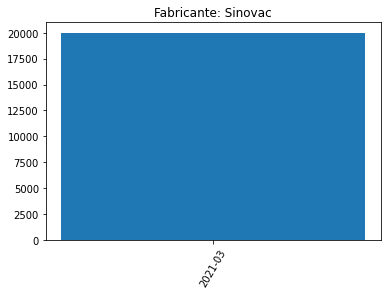

In [12]:
for i in fabAgrMonth.groupby(['vaccine'], as_index=False).mean()['vaccine']:
    fabGroupss = fabAgrMonth.loc[(fabAgrMonth['vaccine'] == i)]
    plt.bar(np.arange(len(fabGroupss['arrived_at'])), fabGroupss['total'])
    plt.xticks(np.arange(len(fabGroupss['arrived_at'])), fabGroupss['arrived_at'],rotation=60)
    plt.title('Fabricante: ' + i)
    plt.show()

# Generar un modelo matemático de predicción basado en regresión, del procesos de vacunación en base al numero actual de vacunados (1 y 2 dosis) y a la llegada de nuevas vacunas.

In [13]:
totalVacunados = pd.read_csv('./datos_crudos/vacunas/vacunas.csv')
totalVacunados['fecha'] = pd.to_datetime(totalVacunados['fecha'],format='%d/%m/%Y')
primeraFechaValida = totalVacunados['fecha'].iloc[0]

print('Primera fecha valida en Ecuador ', primeraFechaValida)

# Expresar las fechas en numero de dias
FMT = '%d/%m/%Y'
date = totalVacunados['fecha']
totalVacunados['fecha'] = date.map(lambda x : (x - primeraFechaValida).days)

totalVacunados.head()

Primera fecha valida en Ecuador  2021-01-21 00:00:00


,fecha,dosis_total,primera_dosis,segunda_dosis
0,0,0,0,0
1,1,108,108,0
2,6,2982,2982,0
3,14,6228,6228,0
4,27,8190,6228,1962


### 1ra Dosis

In [14]:
x1 = totalVacunados['fecha'].values.reshape(-1,1)
y1 = totalVacunados['primera_dosis'].values.reshape(-1,1)

Regresion Lineal

In [15]:
# Creamos el objeto de Regresión Lineal
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(np.array(x1).reshape(-1, 1) ,y1)

LinearRegression()

In [16]:
#Vamos a comprobar:
predLi = regr.predict(x1)
pd.DataFrame({'Real': y1.flatten(), 'Predicción Lineal': predLi.flatten()}).head()

,Real,Predicción Lineal
0,0,-254674.105882
1,108,-246255.489659
2,2982,-204162.408543
3,6228,-136813.478758
4,6228,-27371.467857


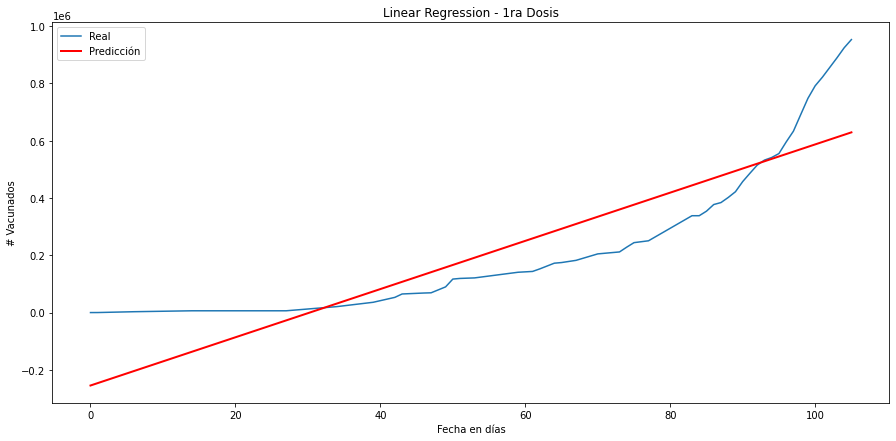

In [17]:
#Graficar
plt.figure(figsize = (15,7))
plt.plot(x1, y1, '-', label ='Real')
plt.plot(x1, regr.predict(x1),  '-', label = 'Predicción', linewidth = 2, color='r')
plt.title('Linear Regression - 1ra Dosis')
plt.xlabel('Fecha en días')
plt.ylabel('# Vacunados')
plt.legend()
plt.show()

Random Forest Regression

In [18]:
RF1 = RandomForestRegressor(n_estimators=10, random_state=0)
RF1.fit(np.array(x1).reshape(-1, 1) ,y1.ravel())

predRF1 = RF1.predict(x1)
pd.DataFrame({'Real': y1.flatten(), 'Predicción RF': predRF1.flatten()}).head()

,Real,Predicción RF
0,0,319.8
1,108,384.6
2,2982,2407.2
3,6228,4929.6
4,6228,16791.0


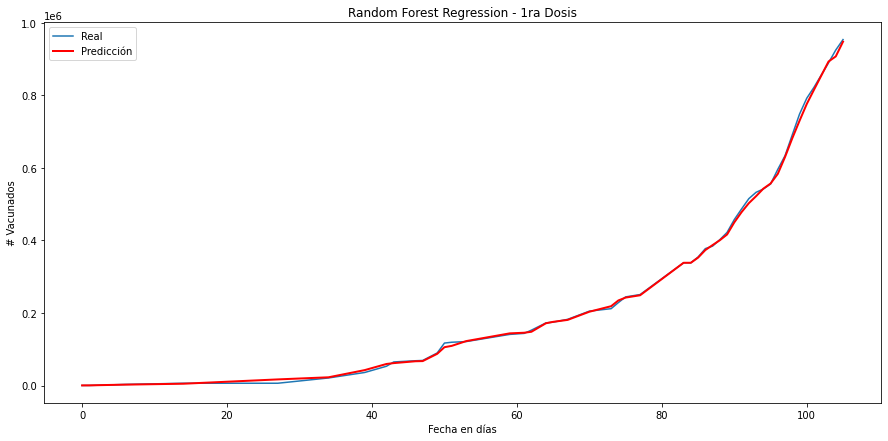

In [19]:
plt.figure(figsize = (15,7))
plt.plot(x1, y1, '-', label ='Real')
plt.plot(x1, RF1.predict(x1),  '-', label = 'Predicción', linewidth = 2, color='r')
plt.title('Random Forest Regression - 1ra Dosis')
plt.xlabel('Fecha en días')
plt.ylabel('# Vacunados')
plt.legend()
plt.show()

### 2da Dosis

In [20]:
x2 = totalVacunados['fecha'].values.reshape(-1,1)
y2 = totalVacunados['segunda_dosis'].values.reshape(-1,1)

Regresion Lineal

In [21]:
# Creamos el objeto de Regresión Lineal
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(np.array(x2).reshape(-1, 1) ,y2)

LinearRegression()

In [22]:
#Vamos a comprobar:
predLi = regr.predict(x2)
pd.DataFrame({'Real': y2.flatten(), 'Predicción Lineal': predLi.flatten()}).head()

,Real,Predicción Lineal
0,0,-93288.419631
1,0,-90305.125542
2,0,-75388.655094
3,0,-51522.302378
4,1962,-12739.479214


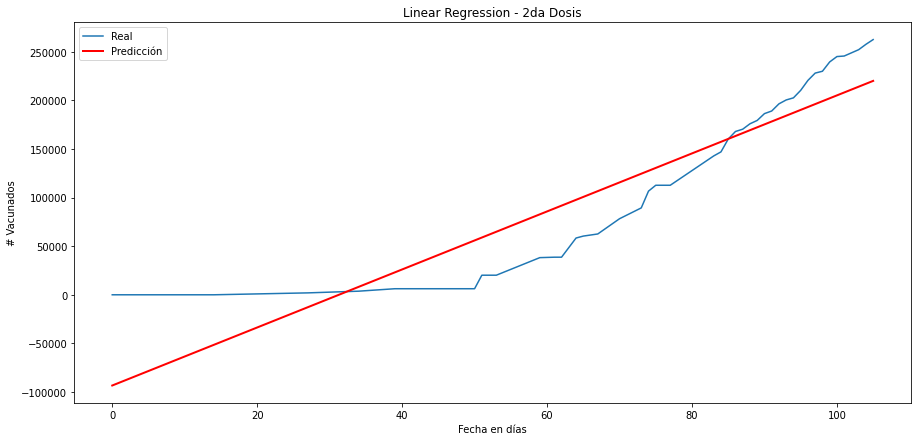

In [23]:
#Graficar
plt.figure(figsize = (15,7))
plt.plot(x2, y2, '-', label ='Real')
plt.plot(x2, regr.predict(x2),  '-', label = 'Predicción', linewidth = 2, color='r')
plt.title('Linear Regression - 2da Dosis')
plt.xlabel('Fecha en días')
plt.ylabel('# Vacunados')
plt.legend()
plt.show()

Random Forest Regression

In [24]:
RF2 = RandomForestRegressor(n_estimators=10, random_state=0)
RF2.fit(np.array(x2).reshape(-1, 1) ,y2.ravel())

predRF2 = RF2.predict(x2)
pd.DataFrame({'Real': y2.flatten(), 'Predicción RF': predRF2.flatten()}).head()

,Real,Predicción RF
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,1962,3164.4


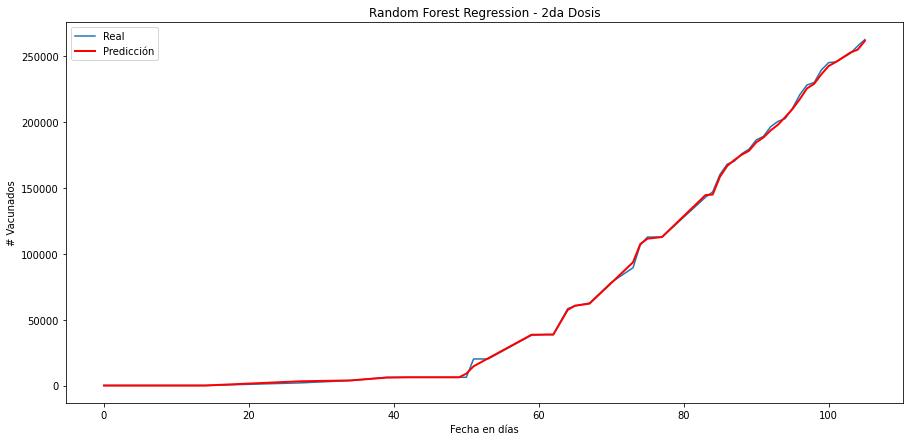

In [25]:
plt.figure(figsize = (15,7))
plt.plot(x2, y2, '-', label ='Real')
plt.plot(x2, RF2.predict(x2),  '-', label = 'Predicción', linewidth = 2, color='r')
plt.title('Random Forest Regression - 2da Dosis')
plt.xlabel('Fecha en días')
plt.ylabel('# Vacunados')
plt.legend()
plt.show()

Podemos notar que el modelo de Random Forest Regression, es mas preciso por ese motivo las siguientes comparaciones las realizaremos con ese modelo.

# Desarrollar y generar un proceso de comparación con al menos dos países (1. Latinoamérica, 1. Europa).

### Perú

In [26]:
peru = pd.read_csv('./Peru.csv')
peru['date'] = pd.to_datetime(peru['date'],format='%Y-%m-%d')

# Expresar las fechas en numero de dias
date = peru['date']
peru['date'] = date.map(lambda x : (x - primeraFechaValida).days)

peru.head()

,location,date,vaccine,source_url,total_vaccinations,people_vaccinated,people_fully_vaccinated
0,Peru,19,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",https://www.datosabiertos.gob.pe/dataset/vacun...,3842,3842,0
1,Peru,20,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",https://www.datosabiertos.gob.pe/dataset/vacun...,20431,20431,0
2,Peru,21,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",https://www.datosabiertos.gob.pe/dataset/vacun...,54281,54281,0
3,Peru,22,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",https://www.datosabiertos.gob.pe/dataset/vacun...,86629,86629,0
4,Peru,23,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",https://www.datosabiertos.gob.pe/dataset/vacun...,105532,105532,0


#### Primera Dosis

In [27]:
xPe1 = peru['date'].values.reshape(-1,1)
yPe1 = peru['people_vaccinated'].values.reshape(-1,1)

RFPer1 = RandomForestRegressor(n_estimators=10, random_state=0)
RFPer1.fit(xPe1, yPe1.ravel())

predRFPer1 = RFPer1.predict(xPe1)
pd.DataFrame({'Real': yPe1.flatten(), 'Predicción RF': predRFPer1.flatten()}).head()

,Real,Predicción RF
0,3842,8885.9
1,20431,22157.1
2,54281,47511.0
3,86629,67070.0
4,105532,105836.5


#### Segunda dosis

In [28]:
xPe2 = peru['date'].values.reshape(-1,1)
yPe2 = peru['people_fully_vaccinated'].values.reshape(-1,1)

RFPer2 = RandomForestRegressor(n_estimators=10, random_state=0)
RFPer2.fit(xPe2, yPe2.ravel())

predRFPer2 = RFPer2.predict(xPe2)
pd.DataFrame({'Real': yPe2.flatten(), 'Predicción RF': predRFPer2.flatten()}).describe()

,Real,Predicción RF
count,87.000000,87.000000
mean,293851.436782,292178.700000
std,239711.349284,239376.163211
min,0.000000,0.000000
25%,8051.000000,8448.450000
50%,300079.000000,298697.800000
75%,530816.500000,525952.450000
max,654463.000000,654220.000000


### Portugal

In [29]:
portugal = pd.read_csv('./Portugal.csv')
portugal['date'] = pd.to_datetime(portugal['date'],format='%Y-%m-%d')

# Expresar las fechas en numero de dias
date = portugal['date']
portugal['date'] = date.map(lambda x : (x - primeraFechaValida).days)

portugal.head()

,location,date,vaccine,source_url,total_vaccinations,people_vaccinated,people_fully_vaccinated
0,Portugal,-25,Pfizer/BioNTech,https://github.com/dssg-pt/covid19pt-data,4963,4963,0
1,Portugal,-24,Pfizer/BioNTech,https://github.com/dssg-pt/covid19pt-data,7754,7754,0
2,Portugal,-23,Pfizer/BioNTech,https://github.com/dssg-pt/covid19pt-data,20368,20368,0
3,Portugal,-22,Pfizer/BioNTech,https://github.com/dssg-pt/covid19pt-data,30543,30543,0
4,Portugal,-21,Pfizer/BioNTech,https://github.com/dssg-pt/covid19pt-data,32749,32749,0


#### Primera Dosis

In [30]:
xPo1 = portugal['date'].values.reshape(-1,1)
yPo1 = portugal['people_vaccinated'].values.reshape(-1,1)

RFPor1 = RandomForestRegressor(n_estimators=10, random_state=0)
RFPor1.fit(xPo1, yPo1.ravel())

predRFPor1 = RFPor1.predict(xPo1)
pd.DataFrame({'Real': yPo1.flatten(), 'Predicción RF': predRFPor1.flatten()}).head()

,Real,Predicción RF
0,4963,5800.3
1,7754,7754.0
2,20368,19106.6
3,30543,26473.0
4,32749,31510.9


#### Segunda Dosis

In [31]:
xPo2 = portugal['date'].values.reshape(-1,1)
yPo2 = portugal['people_fully_vaccinated'].values.reshape(-1,1)

RFPor2 = RandomForestRegressor(n_estimators=10, random_state=0)
RFPor2.fit(xPo2, yPo2.ravel())

predRFPor2 = RFPor2.predict(xPo2)
pd.DataFrame({'Real': yPo2.flatten(), 'Predicción RF': predRFPor2.flatten()}).describe()

,Real,Predicción RF
count,1.330000e+02,1.330000e+02
mean,3.423009e+05,3.404952e+05
std,3.015751e+05,3.003043e+05
min,0.000000e+00,0.000000e+00
25%,3.055300e+04,3.404380e+04
50%,2.759480e+05,2.756465e+05
75%,5.790380e+05,5.793689e+05
max,1.091073e+06,1.076024e+06


## Comparación datos reales

#### Primera Dosis

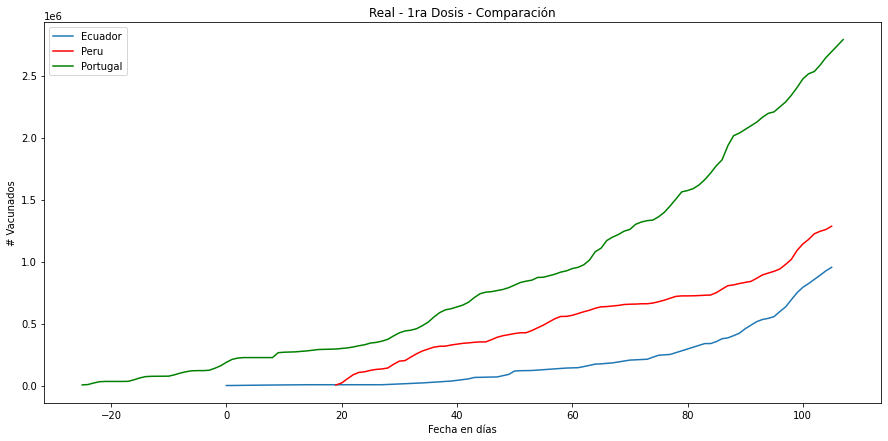

In [32]:
plt.figure(figsize = (15,7))
plt.plot(x1, y1, '-', label ='Ecuador')
plt.plot(xPe1, yPe1, '-', label ='Peru', color='r')
plt.plot(xPo1, yPo1, '-', label ='Portugal', color='g')
plt.title('Real - 1ra Dosis - Comparación')
plt.xlabel('Fecha en días')
plt.ylabel('# Vacunados')
plt.legend()
plt.show()

#### Segunda dosis

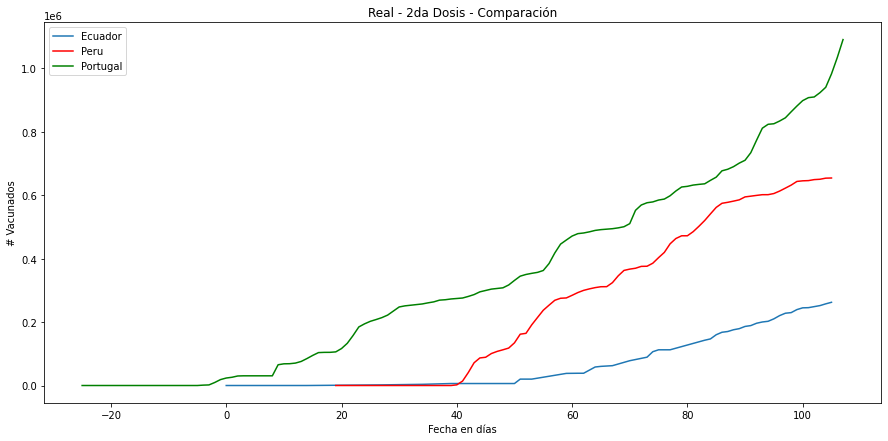

In [33]:
plt.figure(figsize = (15,7))
plt.plot(x2, y2, '-', label ='Ecuador')
plt.plot(xPe2, yPe2, '-', label ='Peru', color='r')
plt.plot(xPo2, yPo2, '-', label ='Portugal', color='g')
plt.title('Real - 2da Dosis - Comparación')
plt.xlabel('Fecha en días')
plt.ylabel('# Vacunados')
plt.legend()
plt.show()

## Comparación Modelos de Regresión

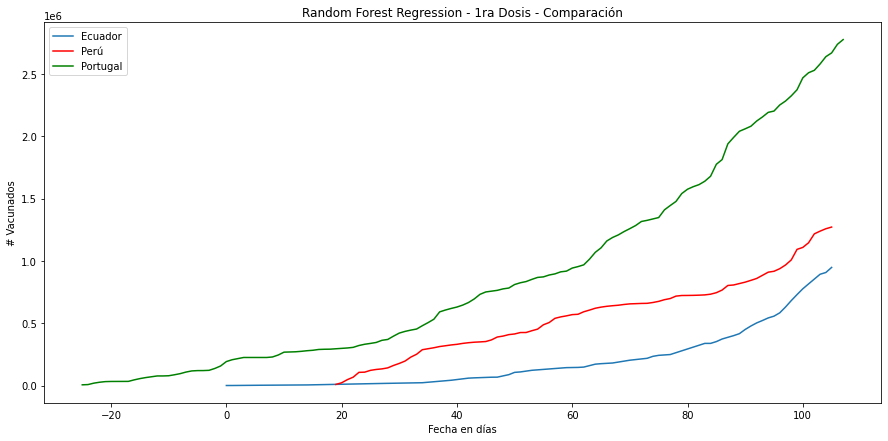

In [34]:
plt.figure(figsize = (15,7))
plt.plot(x1, RF1.predict(x1),  '-', label = 'Ecuador')
plt.plot(xPe1, RFPer1.predict(xPe1),  '-', label = 'Perú', color='r')
plt.plot(xPo1, RFPor1.predict(xPo1),  '-', label = 'Portugal', color='g')
plt.title('Random Forest Regression - 1ra Dosis - Comparación')
plt.xlabel('Fecha en días')
plt.ylabel('# Vacunados')
plt.legend()
plt.show()

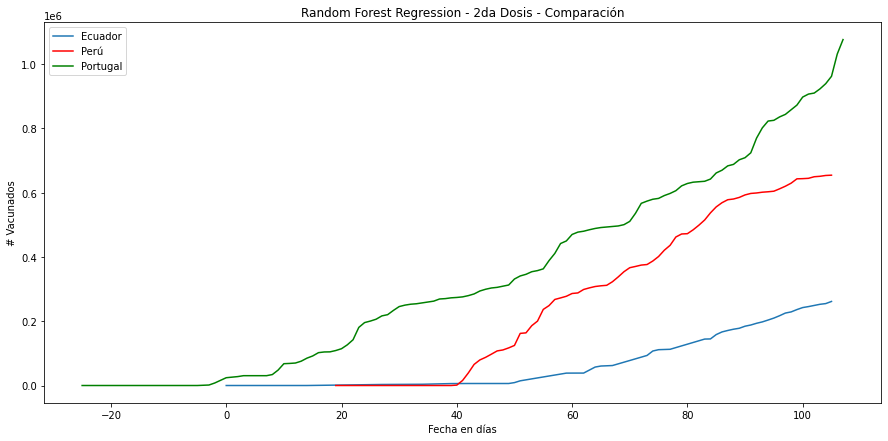

In [35]:
plt.figure(figsize = (15,7))
plt.plot(x2, RF2.predict(x2),  '-', label = 'Ecuador')
plt.plot(xPe2, RFPer2.predict(xPe2),  '-', label = 'Perú', color='r')
plt.plot(xPo2, RFPor2.predict(xPo2),  '-', label = 'Portugal', color='g')
plt.title('Random Forest Regression - 2da Dosis - Comparación')
plt.xlabel('Fecha en días')
plt.ylabel('# Vacunados')
plt.legend()
plt.show()

# Identificar cual es la fecha tentativa en la que todos los Ecuatorianos podrán ser vacunados con las dos dosis. 

In [36]:
maximo = max(x2)+1
last = regr.predict([maximo])
while last <= 17370000:
    maximo = maximo+1
    last = regr.predict([maximo])

ultimaVacuna = primeraFechaValida + datetime.timedelta(days=np.float64(maximo[0]))
print('La poblacion ecuatoriana (17.37 millones), estará inmunizada en su totalidad (regresion lineal) el dia ',ultimaVacuna)

La poblacion ecuatoriana (17.37 millones), estará inmunizada en su totalidad (regresion lineal) el dia  2037-01-31 00:00:00


Nota: no se pudo realizar una estimacion con la regresion random forest, ya que existen muy pocos datos, la regresion llega a un punto en que es lineal, por ese motivo no se realizo la prediccion con dicha regresión